# Restaurant Visitor Forecasting by GooseLearning

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import catboost

pd.options.display.max_columns = 1000

In [2]:
def catboost_save_dataset(X, y, path):
    Y = pd.DataFrame({'__target__': y})
    Y.index = X.index
    dataset = pd.concat([Y, X], axis=1)
    dataset.to_csv(path, sep='\t', header=False, index=False)


def catboost_save_columns(columns, cat_features, path):
    file = open(path, "w")
    file.write('0\tTarget')
    for index, is_cat in enumerate(columns.isin(cat_features), 1):
        file.write('\n{0}\t{1}'.format(index, 'Categ' if is_cat else 'Auxiliary'))


def catboost_save(X_train, X_test, y_train, y_test, cat_features, train_path, test_path, columns_path):
    catboost_save_dataset(X_train, y_train, train_path)
    catboost_save_dataset(X_test, y_test, test_path)
    catboost_save_columns(pd.Series(list(X_train)), cat_features, columns_path)

In [3]:
data = {
    'stores':  pd.read_csv('result/stores.csv'),
    'reserve': pd.read_csv('result/reserve.csv'),
    'dates':   pd.read_csv('result/dates.csv'),

    'train':   pd.read_csv('dataset/air_visit_data.csv'),
    'result':  pd.read_csv('dataset/sample_submission.csv'),
}

## Обработка данных

### Обрабатываем `train` и `result`

Приводим к единому формату

In [4]:
data['train']['id'] = data['train']['air_store_id'] + '_' + data['train']['visit_date']

data['result']['air_store_id'] = [id[:20] for id in data['result']['id']]
data['result']['visit_date']   = [id[21:] for id in data['result']['id']]

Добавляем дополнительные колонки даты

In [5]:
data['train']  = pd.merge(data['train'],  data['dates'], how='left', on=['visit_date'])
data['result'] = pd.merge(data['result'], data['dates'], how='left', on=['visit_date'])

In [6]:
print('train ', data['train'].shape)
print('result', data['result'].shape)

data['train'].head()

train  (252108, 12)
result (32019, 12)


,air_store_id,visit_date,visitors,id,visit_holiday,visit_day,visit_month,visit_year,visit_dow,visit_work,visit_weekend,visit_date_int
0,air_ba937bf13d40fb24,2016-01-13,25,air_ba937bf13d40fb24_2016-01-13,0,13,1,2016,2,True,False,20160113
1,air_ba937bf13d40fb24,2016-01-14,32,air_ba937bf13d40fb24_2016-01-14,0,14,1,2016,3,True,False,20160114
2,air_ba937bf13d40fb24,2016-01-15,29,air_ba937bf13d40fb24_2016-01-15,0,15,1,2016,4,True,False,20160115
3,air_ba937bf13d40fb24,2016-01-16,22,air_ba937bf13d40fb24_2016-01-16,0,16,1,2016,5,False,True,20160116
4,air_ba937bf13d40fb24,2016-01-18,6,air_ba937bf13d40fb24_2016-01-18,0,18,1,2016,0,True,False,20160118


### Обрабатываем `reserve`

Добавляем `reserve` в `train` / `result` 

In [7]:
for ds in ['train', 'result']:
    data[ds] = pd.merge(data[ds], data['reserve'], how='left', on=['air_store_id', 'visit_date'])

In [8]:
print('train ', data['train'].shape)
print('result', data['result'].shape)

data['train'].head()

train  (252108, 15)
result (32019, 15)


,air_store_id,visit_date,visitors,id,visit_holiday,visit_day,visit_month,visit_year,visit_dow,visit_work,visit_weekend,visit_date_int,reserve_visitors,reserve_visitors_all,reserve_visitors_competitor
0,air_ba937bf13d40fb24,2016-01-13,25,air_ba937bf13d40fb24_2016-01-13,0,13,1,2016,2,True,False,20160113,0.0,216.0,216.0
1,air_ba937bf13d40fb24,2016-01-14,32,air_ba937bf13d40fb24_2016-01-14,0,14,1,2016,3,True,False,20160114,0.0,188.0,188.0
2,air_ba937bf13d40fb24,2016-01-15,29,air_ba937bf13d40fb24_2016-01-15,0,15,1,2016,4,True,False,20160115,0.0,299.0,299.0
3,air_ba937bf13d40fb24,2016-01-16,22,air_ba937bf13d40fb24_2016-01-16,0,16,1,2016,5,False,True,20160116,0.0,348.0,348.0
4,air_ba937bf13d40fb24,2016-01-18,6,air_ba937bf13d40fb24_2016-01-18,0,18,1,2016,0,True,False,20160118,0.0,146.0,146.0


### Обрабатываем `stores`

Добавляем информацию о посещениях

In [9]:
for op_type in ['sum', 'mean', 'median', 'min', 'max', 'count']:
    tmp = getattr(
        data['train']
            .groupby(['air_store_id', 'visit_dow'], as_index=False)
            [['visitors']],
        op_type,
    )().rename(columns={
        'visitors': 'visitors_' + op_type,
    })
    
    data['stores'] = pd.merge(data['stores'], tmp, how='left', on=['air_store_id', 'visit_dow'])

In [10]:
print('stores', data['stores'].shape)

data['stores'].head()

stores (5803, 13)


,air_store_id,visit_dow,air_genre_name,air_area_name,latitude,longitude,city,visitors_sum,visitors_mean,visitors_median,visitors_min,visitors_max,visitors_count
0,air_0f0cdeee6c9bf3d7,0,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Osaka,609.0,16.916667,15.0,2.0,39.0,36.0
1,air_7cc17a324ae5c7dc,0,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Osaka,219.0,9.125000,7.0,1.0,34.0,24.0
2,air_fee8dcf4d619598e,0,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Osaka,813.0,20.325000,18.5,7.0,39.0,40.0
3,air_a17f0778617c76e2,0,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Osaka,158.0,26.333333,27.5,19.0,31.0,6.0
4,air_83db5aff8f50478e,0,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tokyo,202.0,6.516129,6.0,1.0,13.0,31.0


Добавляем `stores` в `train` / `result`

In [11]:
for ds in ['train', 'result']:
    data[ds] = pd.merge(data[ds], data['stores'], how='left', on=['air_store_id', 'visit_dow'])
    
data['result'] = data['result'].fillna(0)

In [12]:
print('train ', data['train'].shape)
print('result', data['result'].shape)

data['train'].head()

train  (252108, 26)
result (32019, 26)


,air_store_id,visit_date,visitors,id,visit_holiday,visit_day,visit_month,visit_year,visit_dow,visit_work,visit_weekend,visit_date_int,reserve_visitors,reserve_visitors_all,reserve_visitors_competitor,air_genre_name,air_area_name,latitude,longitude,city,visitors_sum,visitors_mean,visitors_median,visitors_min,visitors_max,visitors_count
0,air_ba937bf13d40fb24,2016-01-13,25,air_ba937bf13d40fb24_2016-01-13,0,13,1,2016,2,True,False,20160113,0.0,216.0,216.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tokyo,1526.0,23.843750,25.0,7.0,57.0,64.0
1,air_ba937bf13d40fb24,2016-01-14,32,air_ba937bf13d40fb24_2016-01-14,0,14,1,2016,3,True,False,20160114,0.0,188.0,188.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tokyo,1319.0,20.292308,21.0,2.0,54.0,65.0
2,air_ba937bf13d40fb24,2016-01-15,29,air_ba937bf13d40fb24_2016-01-15,0,15,1,2016,4,True,False,20160115,0.0,299.0,299.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tokyo,2258.0,34.738462,35.0,4.0,61.0,65.0
3,air_ba937bf13d40fb24,2016-01-16,22,air_ba937bf13d40fb24_2016-01-16,0,16,1,2016,5,False,True,20160116,0.0,348.0,348.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tokyo,1825.0,27.651515,27.0,6.0,53.0,66.0
4,air_ba937bf13d40fb24,2016-01-18,6,air_ba937bf13d40fb24_2016-01-18,0,18,1,2016,0,True,False,20160118,0.0,146.0,146.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tokyo,784.0,13.754386,12.0,2.0,34.0,57.0


## Обучение

In [13]:
columns = pd.Series([col for col in data['train'] if col not in ['id', 'visit_date', 'visitors']])
cat_features = [
    'air_store_id',
    'visit_holiday',
    'visit_day',
    'visit_month',
    'visit_year',
    'visit_dow',
    'visit_work',
    'visit_weekend',
    'air_genre_name',
    'air_area_name',
    'city',
]

Усиливаем вес для периода `2016-04-23` - `2016-05-31`

In [14]:
train_good = data['train'][pd.to_datetime(data['train']['visit_date']).isin(pd.date_range('2016-04-23', '2016-05-31'))]
train = pd.concat([data['train'], train_good, train_good])

In [15]:
X_all = train[columns]
y_all = np.log1p(train['visitors'])

stratify = np.clip(train['visitors'], a_min=0, a_max=100)

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all,
    test_size=0.2, 
    random_state=78235,
    stratify=stratify,
)

In [16]:
train_path   = 'catboost/goose/train.tsv'
test_path    = 'catboost/goose/test.tsv'
result_path  = 'catboost/goose/result.tsv'
columns_path = 'catboost/goose/columns.cd'
model_path   = 'catboost/goose/model.bin'

In [17]:
catboost_save(X_train, X_test, y_train, y_test, cat_features, train_path, test_path, columns_path)

In [23]:
model = catboost.CatBoostRegressor()
model.load_model(model_path)

In [24]:
catboost_save_dataset(data['result'][columns], [0] * len(data['result']), result_path)
result_pool = catboost.Pool(result_path, column_description=columns_path)
result_preds = model.predict(result_pool)
data['result']['visitors'] = np.clip(np.expm1(result_preds), a_min=0, a_max=10000)

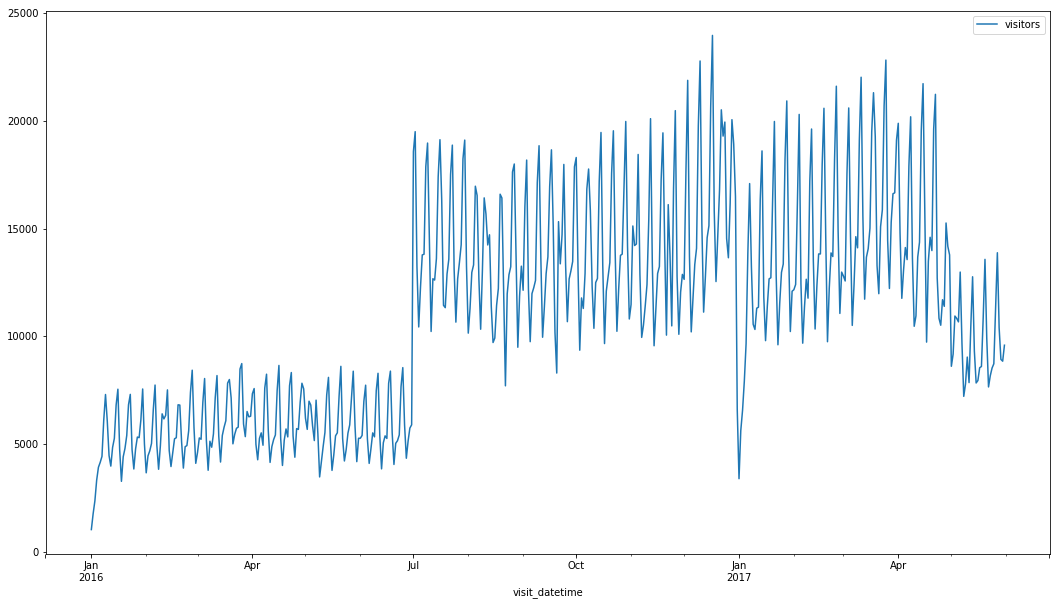

In [25]:
data['full'] = pd.concat([data['train'], data['result']])
data['full']['visit_datetime'] = pd.to_datetime(data['full']['visit_date'])
data['full'].groupby(['visit_datetime'])[['visitors']].sum().plot(figsize=(18,10))
pyplot.show()

In [26]:
result = data['result'][['id', 'visitors']]
result = result.groupby('id', as_index=False).mean()

In [27]:
result.to_csv('result/submission.csv', index=False)